In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('movies.txt', 'r', encoding='utf-8').read().splitlines()
words[:10]

['Toy Story',
 'Jumanji',
 'Grumpier Old Men',
 'Waiting to Exhale',
 'Father of the Bride Part II',
 'Heat',
 'Sabrina',
 'Tom and Huck',
 'Sudden Death',
 'GoldenEye']

In [3]:
len(words)

42259

In [4]:
import unicodedata
import re

def clean(word):
    word = unicodedata.normalize('NFKD', word)
    word = word.lower()
    # Keep lowercase letters, digits, spaces, apostrophes, hyphens
    word = re.sub(r"[^a-z0-9 '\-]", '', word)
    return word.strip()

In [5]:
chars = sorted(list(set(''.join(words))))
print(chars)

[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '¢', '£', 'ª', '°', '²', '³', '·', '½', '¿', 'À', 'Á', 'Â', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ö', '×', 'Ú', 'Ü', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'ù', 'ú', 'û', 'ü', 'ā', 'ą', 'Ć', 'ć', 'ē', 'ę', 'ě', 'ğ', 'İ', 'ı', 'ł', 'ń', 'ņ', 'œ', 'ś', 'Ş', 'ş', 'Š', 'š', 'ū', 'ů', 'ż', 'Ž', 'ž', 'Α', 'Β', 'Γ', 'Δ', 'Θ', 'Κ', 'Λ', 'Μ', 'Ν', 'Ξ', 'Ο', 'Π', 'Σ', 'Τ', 'Υ', 'Φ', 'ά', 'έ', 'ή', 'ί', 'α', 'γ', 'δ', 'ε', 'η', 'ι', 'κ', 'λ', 'μ', 'ν', 'ο', 'π', 'ρ', 'ς', 'σ', 'τ', 'υ', 'φ', 'χ',

In [6]:
# cleaned_words = [clean(w) for w in words if w.strip() != '']
cleaned_words = [clean(w) for w in words if clean(w).strip() != '']

In [7]:
chars = sorted(list(set(''.join(cleaned_words))))

In [8]:
chars

[' ',
 "'",
 '-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [9]:
chars = sorted(list(set(''.join(cleaned_words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [10]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(cleaned_words)

In [12]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(cleaned_words):  
  X, Y = [], []
  
  for w in cleaned_words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(cleaned_words))
n2 = int(0.9*len(cleaned_words))
Xtr,  Ytr  = build_dataset(cleaned_words[:n1])     # 80%
Xdev, Ydev = build_dataset(cleaned_words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(cleaned_words[n2:])     # 10%

torch.Size([603369, 8]) torch.Size([603369])
torch.Size([77430, 8]) torch.Size([77430])
torch.Size([76752, 8]) torch.Size([76752])


In [13]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> s
.......s --> u
......su --> m
.....sum --> m
....summ --> e
...summe --> r
..summer -->  
.summer  --> w
summer w --> i
ummer wi --> t
mmer wit --> h
mer with -->  
er with  --> m
r with m --> o
 with mo --> n
with mon --> i
ith moni --> k
th monik --> a
h monika --> .
........ --> c


In [14]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [15]:
torch.manual_seed(42); # seed rng for reproducibility


In [16]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

78568


In [17]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.6782
  10000/ 200000: 2.0535
  20000/ 200000: 1.8266
  30000/ 200000: 1.8991
  40000/ 200000: 2.4856
  50000/ 200000: 1.9329
  60000/ 200000: 1.9220
  70000/ 200000: 1.6011
  80000/ 200000: 1.9591
  90000/ 200000: 1.5719
 100000/ 200000: 1.8994
 110000/ 200000: 1.4480
 120000/ 200000: 2.2128
 130000/ 200000: 1.6084
 140000/ 200000: 2.0671
 150000/ 200000: 1.5990
 160000/ 200000: 1.9355
 170000/ 200000: 2.2804
 180000/ 200000: 1.8031
 190000/ 200000: 1.9188


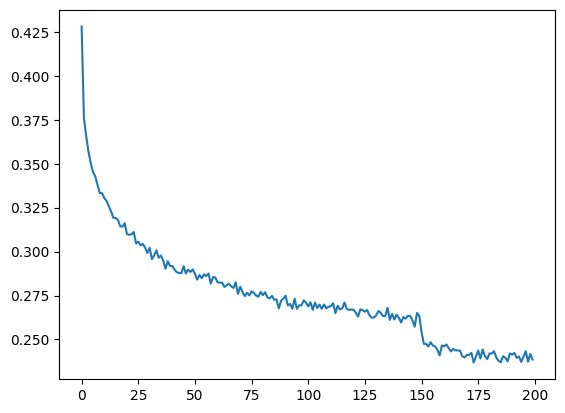

In [18]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))


In [19]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [20]:

# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.709650993347168
val 1.789048194885254


In [21]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

caredison lival annamaroon man.
murder of the detective 3.
puff petheo.
gurraughter.
the hole.
sarolation benesifull.
amripal 2.
yoash ultaord war.
the ranfight.
zene visitan.
the oselley.
the best darkness.
when election of the fermet sp megony.
equiumanchorkesweet.
new world.
ghostoppea.
old funning fayehing dele.
centa shacher.
finsteined tears.
matterlo.
